In [2]:
from tank_kills_v3 import TankKills
import random
from pynput.keyboard import Controller,Key
import time
import pygame
import matplotlib.pyplot as plt
import numpy as np
import json
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/q_table_tank_kills')


In [3]:
all_actions = ["up","right","down","left"]

### Loading Q_table

In [4]:
with open('q_table.json','r') as f:
    data = json.load(f)
q_table = np.array(data['q_table'])

In [5]:
test_q_table = q_table

In [6]:
visual_table = np.zeros((600,600))
for i in range(0,600):
    for j in range(0,600):
        if sum(test_q_table[i*j]) == 0:
            visual_table[i][j] = 5
        else:
            # visual_table[i][j] = 1
            visual_table[i][j] = test_q_table[i*j].argmax()

### Plotting explored states with their action values

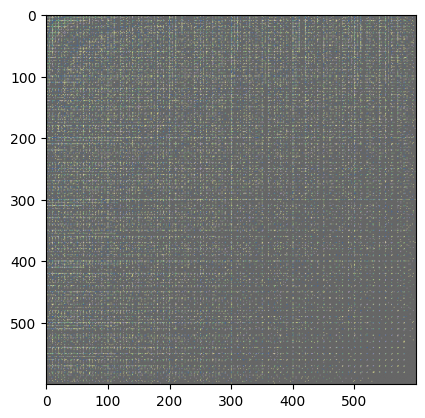

In [7]:
plt.imshow(visual_table,cmap='Accent')
plt.show()

### Function to save Q_table

In [8]:
def save_q_tabel():
    data = {}
    data['q_table'] = q_table.tolist()
    with open('q_table.json','w') as f:
        json.dump(data,f)

In [10]:
# state-action values for spawn point
q_table[300*300]

array([-50.33979676, -50.00782127, -49.98962609, -50.0087734 ])

### Parameters

In [11]:
num_episodes = 30
# max_steps_per_episode = 5
learning_rate = 0.1 # alpha
discount_factor = 0.90 # gamma

exploration_rate = 1
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.007

### Training loop

In [12]:
rewards_all_episodes = []
all_actions_taken = []
no_of_actions_each_episode = []

for episode in range(num_episodes):
    print(f"-------Game: {episode+1}/{num_episodes}-------")

    # Creating new game enviroment with screen res. of 600 x600
    # Initializing variables
    env = TankKills(600,600)
    running = True
    reward_current_episode = 0

    # Starting state is spawn co-ordinates(x,y) of player
    state = 300*400
    reward = 0
    action_taken_in_episode = 0
    actions_taken_in_episode  = []

    while running:

        # Setting Reward to zero
        reward = 0
        # Exploration rate threshold from random uni. Distribution
        exploration_rate_threshold = random.uniform(0,1)
        # E-greedy for exploration vs exploitation
        if exploration_rate_threshold > exploration_rate:
            action = np.argmax(q_table[state,:])
        else:
            action = random.randint(0,3)
        
        # Taking action from using either q_table or e-greedy policy
        # pp is player position cordinates
        # ep is enemy position cordinates
        running,reward,score,pp,ep = env.play(action=all_actions[action])

        # New state is product of x and y co-ordinate of player_position
        new_state = int(pp[0])*int(pp[1])

        # Bellman's Equation for updating Q values
        q_table[state,action] = q_table[state,action] * (1-learning_rate) + learning_rate*(reward+discount_factor*np.max(q_table[new_state,:]))
        # Transition to new state
        state = new_state

        # Keeping track of rewards and actions taken
        all_actions_taken.append(action)
        actions_taken_in_episode.append(action)
        action_taken_in_episode += 1
        reward_current_episode += reward

        # Breaking if game is completed
        if not running:
            pygame.display.quit()
            break
        
        # Decaying Exploration rate
        exploration_rate = min_exploration_rate+(max_exploration_rate-min_exploration_rate)*np.exp(-exploration_decay_rate*episode)
    
    # Tensorboard stuff
    writer.add_scalar('Score',score,episode)
    writer.add_scalar('Rewards',reward_current_episode,episode)
    writer.add_scalar('No. of actions',action_taken_in_episode,episode)
    writer.add_histogram('Actions Taken',np.array(actions_taken_in_episode))
    writer.close()

    # Keeping Track of rewards nad actions
    rewards_all_episodes.append(reward_current_episode)
    no_of_actions_each_episode.append(action_taken_in_episode)
    print(f"-- Score: {score}")
    print(f"-- Total Actions Taken: {action_taken_in_episode}")
    pygame.display.quit()

    # Saving Q_table after Each episode
    save_q_tabel()

-------Game: 1/30-------
-- Score: 1
-- Total Actions Taken: 2651
-------Game: 2/30-------
-- Score: 3
-- Total Actions Taken: 3056
-------Game: 3/30-------
-- Score: 0
-- Total Actions Taken: 2026
-------Game: 4/30-------
-- Score: 0
-- Total Actions Taken: 2086
-------Game: 5/30-------
-- Score: 2
-- Total Actions Taken: 5751
-------Game: 6/30-------
-- Score: 0
-- Total Actions Taken: 2036
-------Game: 7/30-------
-- Score: 1
-- Total Actions Taken: 2430
-------Game: 8/30-------
-- Score: 1
-- Total Actions Taken: 3428
-------Game: 9/30-------
-- Score: 2
-- Total Actions Taken: 3008
-------Game: 10/30-------
-- Score: 0
-- Total Actions Taken: 2041
-------Game: 11/30-------
-- Score: 2
-- Total Actions Taken: 3114
-------Game: 12/30-------
-- Score: 0
-- Total Actions Taken: 2061
-------Game: 13/30-------
-- Score: 0
-- Total Actions Taken: 2016
-------Game: 14/30-------
-- Score: 0
-- Total Actions Taken: 2051
-------Game: 15/30-------
-- Score: 0
-- Total Actions Taken: 2091
----

In [13]:
pygame.display.quit()

### Q Table values of spawn location

In [15]:
print(q_table[300*300])

[-25.45484839 -22.89869287 -25.52923967 -24.5810461 ]


### Rewards per game

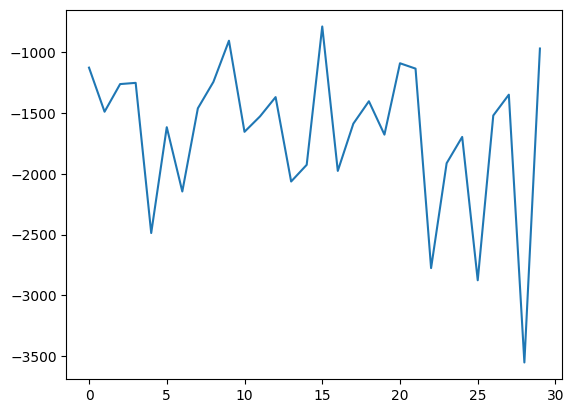

In [16]:
plt.plot(rewards_all_episodes)
plt.show()

### Number of actions each game

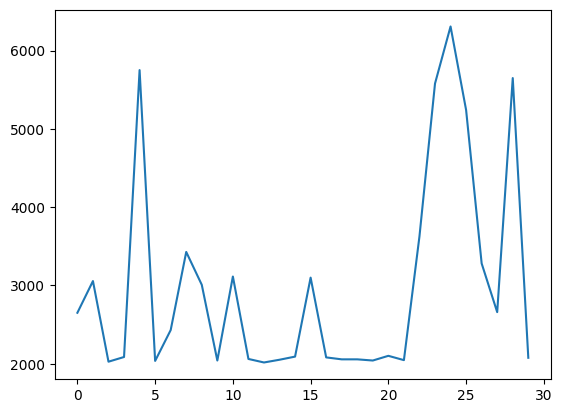

In [17]:
plt.plot(no_of_actions_each_episode)
plt.show()

### Distribution of all actions

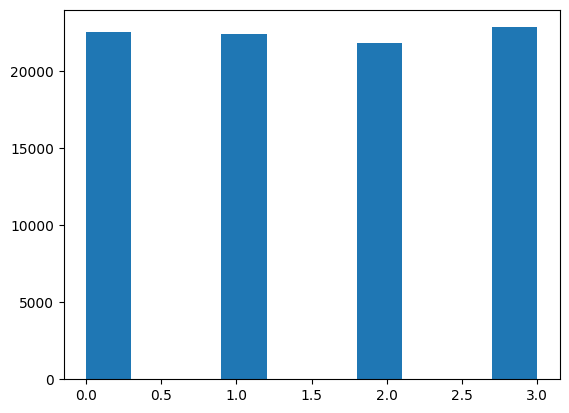

In [18]:
plt.hist(all_actions_taken)
plt.show()

### Playing Using Q_table

In [21]:
env = TankKills(600,600)
running = True
state = 300*400
episode = 1
while running:
    exploration_rate_threshold = random.uniform(0,1)
        # E-greedy for exploration vs exploitation
    if exploration_rate_threshold > exploration_rate:
        action = np.argmax(q_table[state,:])
    else:
        action = random.randint(0,3)
    running,reward,score,pp,ep = env.play(all_actions[action] )
    state = int(pp[0])*int(pp[1])
    exploration_rate = min_exploration_rate+(max_exploration_rate-min_exploration_rate)*np.exp(-exploration_decay_rate*episode)
    episode += 1
    if not running:
            pygame.display.quit()
            break
    

## *Observations*

![q_table](explored_states.png)
> q_table with explored area,The area in green is unexplored.
- The state space was too large to use q_tables.
- It is hard to explore 36,000 states.
- The only thing our agent knew was its co-ordinates nothing else.
- Its like a blnid folded person trying to hit target which spawns randomly anywhere in a larger area.(almost impossible)
- Policy was as expcted
    - Camping spawn while rotating.
    - Exploring sideways with a zig-zag movement to check if it can hit enemy.
    - This policy is almost what a human would perform like in same scenerio.